<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [4]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22797 sha256=e291b91e8e06f9261182264540446579faf56538bddbc68ea253995cfae95de2
  Stored in directory: /tmp/pip-ephem-wheel-cache-zn56ul_y/wheels/75/1b/42/f97112e5f6075e9001855665770761aab12d91e505661db186
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [5]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [6]:
ptu.set_gpu_mode(True)

# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

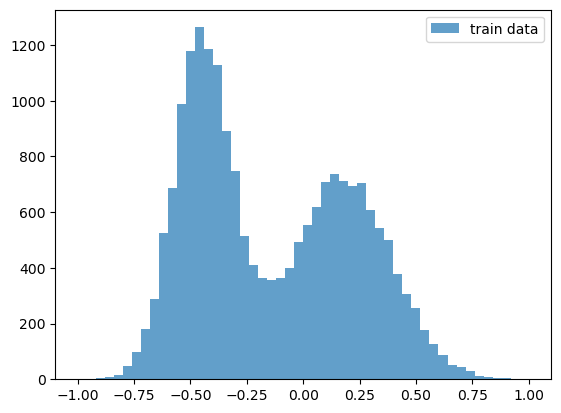

In [7]:
visualize_q1_dataset()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

### Solution

In [9]:
def train(generator, critic, c_loss_fn, g_loss_fn, train_loader, g_optimizer, c_optimizer, n_critic=1, g_scheduler=None, c_scheduler=None, weight_clipping=None):
    """
    generator: 
    critic: discriminator in 1ab, general model otherwise
    loss_fn
    train_loader: instance of DataLoader class
    optimizer: 
    ncritic: how many critic gradient steps to do for every generator step
    """
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        x = x.to(ptu.device).float()
        c_loss = c_loss_fn(generator, critic, x)
        c_optimizer.zero_grad()
        c_loss.backward()
        c_optimizer.step()
        c_losses.append(c_loss.item())
        if weight_clipping is not None:
            for param in critic.parameters():
                param.data.clamp_(-weight_clipping, weight_clipping)

        if i % n_critic == 0:  # generator step
            g_loss = g_loss_fn(generator, critic, x)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)

def train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    if 'optim_cls' in train_args:
        g_optimizer = train_args['optim_cls'](generator.parameters(), lr=lr)
        c_optimizer = train_args['optim_cls'](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))
        
    if train_args.get('lr_schedule', None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(g_optimizer, train_args['lr_schedule'])
        c_scheduler = optim.lr_scheduler.LambdaLR(c_optimizer, train_args['lr_schedule'])
    else:
        g_scheduler = None
        c_scheduler = None 

    train_losses = dict()
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        if epoch == 1:
            epoch1_snapshot = get_training_snapshot(generator, critic)
        generator.train()
        critic.train()
        train_loss = train(generator, critic, c_loss_fn, g_loss_fn, train_loader, 
                           g_optimizer, c_optimizer, n_critic=train_args.get('n_critic', 0), 
                           g_scheduler=g_scheduler, c_scheduler=c_scheduler,
                           weight_clipping=train_args.get('weight_clipping', None))
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get('q1', False):  # q1, return the snapshots
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *epoch1_snapshot, *final_snapshot]
    else:
        return train_losses

def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-1, 1, 1000)
    samples = ptu.get_numpy(generator.sample(n_samples))
    critic_output = ptu.get_numpy(critic(ptu.FloatTensor(xs).unsqueeze(1)))
    return samples, xs, critic_output

class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        layers = []
        self.latent_dim = latent_dim
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
        # self.log_scale = nn.Parameter(torch.zeros(data_dim), requires_grad=True)
    
    def forward(self, z):
        return torch.tanh(self.mlp(z)) # * self.log_scale.exp()
        return self.mlp(z) # * self.log_scale.exp()
        
    def sample(self, n):
        # n is the number of samples to return
        z = ptu.normal(ptu.zeros(n, self.latent_dim), ptu.ones(n, self.latent_dim))
        return self.forward(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
    
    def forward(self, z):
        return torch.sigmoid(self.mlp(z)) 
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return (1 - critic(fake_data)).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final

### Results

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

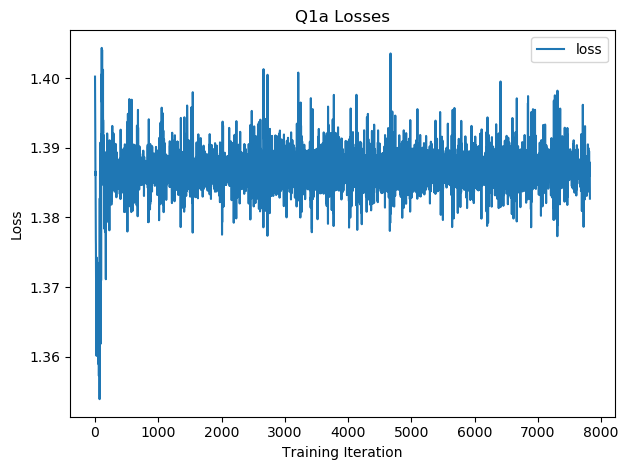

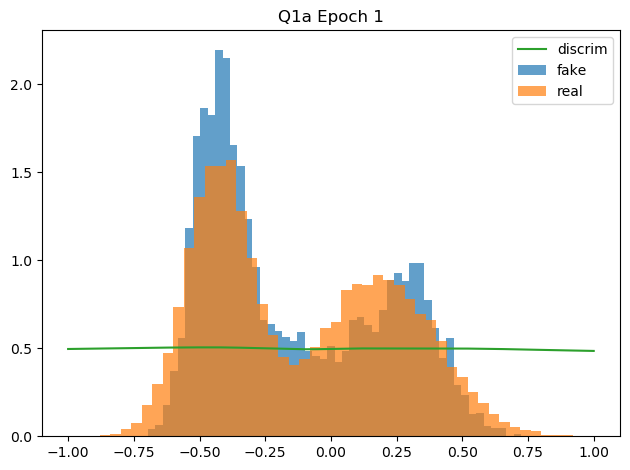

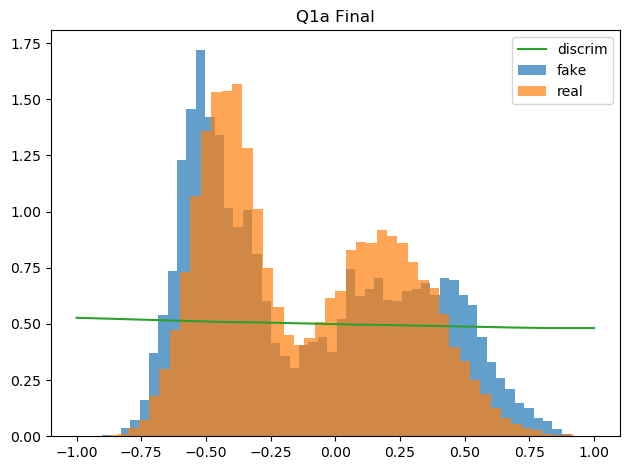

In [10]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate objectives:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G)} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z)))$$

 ### Solution

In [11]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return  - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final
     

 ### Results

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

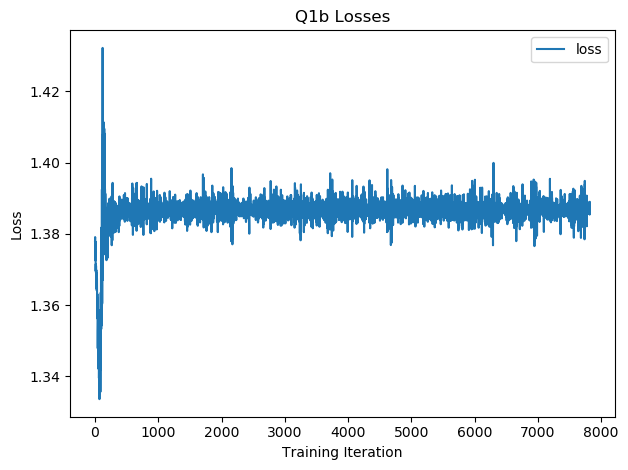

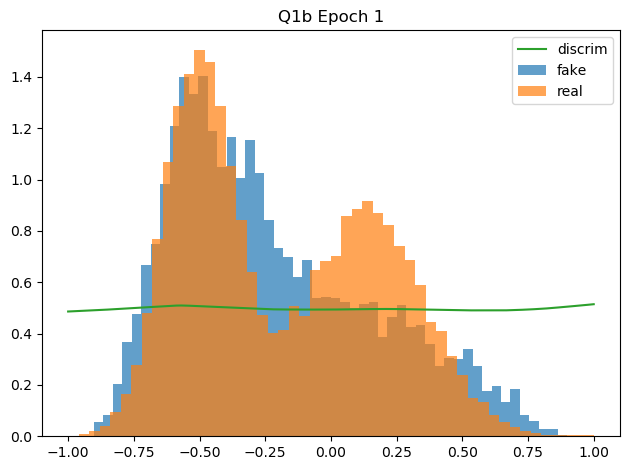

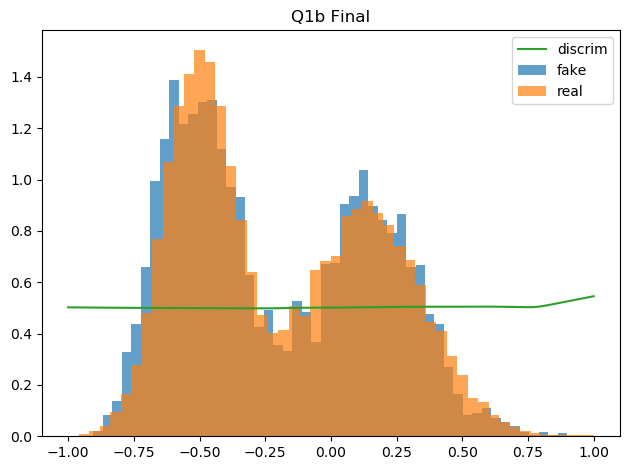

In [12]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train a GAN on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


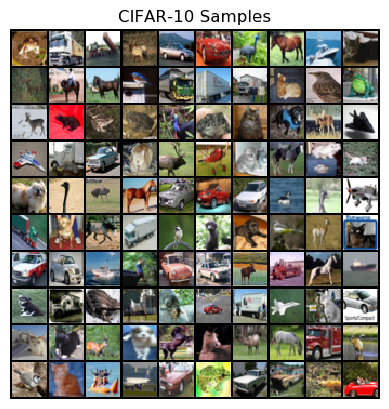

In [13]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf) (see page 17), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
The discriminator (no BatchNorm!).
```
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
```


**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

 ### Models

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(real_samples.device)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)  # Use reshape instead of view
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output

class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super(Upsample_Conv2d, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        return x

class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super(Downsample_Conv2d, self).__init__()
        self.space_to_depth = SpaceToDepth(block_size=2)
        self.conv = nn.Conv2d(in_dim * 4, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.space_to_depth(x)
        x = self.conv(x)
        return x

class ResNetBlockUp(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        )
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        return self.block(x) + self.shortcut(x)

class ResNetBlockDown(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3), padding=1):
        super().__init__()
        # Main path: includes ReLU, downsample then convolutions without batch norm
        self.main_path = nn.Sequential(
            nn.ReLU(),
            Downsample_Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, stride=1, padding=padding)
        )
        # Shortcut path: downsample followed by a convolution, matching the main path's output dimensions
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), stride=1, padding=0)

    def forward(self, x):
        main_path = self.main_path(x)
        shortcut = self.shortcut(x)
        # Adding the main path and the shortcut together
        return main_path + shortcut

class Generator(nn.Module):
    def __init__(self, n_samples=1024, n_filters=128):
        super().__init__()
        self.init_size = n_samples // 16
        self.l1 = nn.Sequential(nn.Linear(128, 4*4*256))
        self.conv_blocks = nn.Sequential(
            ResNetBlockUp(256, n_filters),
            ResNetBlockUp(n_filters, n_filters),
            ResNetBlockUp(n_filters, n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 256, 4, 4)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super(Discriminator, self).__init__()
        # Initial convolutional layer
        self.initial = ResNetBlockDown(3, n_filters)
        
        # Following ResNet blocks with downsampling
        self.block1 = ResNetBlockDown(n_filters, n_filters)
        self.block2 = ResNetBlockDown(n_filters, n_filters)
        
        # Final ReLU activation
        self.relu = nn.ReLU()

        # The final linear layer will be applied after global sum pooling
        self.final = nn.Linear(n_filters, 1)
        
    def forward(self, x):
        x = self.initial(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.relu(x)
        
        # Global sum pooling
        x = torch.sum(x, dim=[2, 3])
        
        # Final linear layer
        x = self.final(x)
        
        return x
    

    
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(train_data.shape)
    # Preprocessing the data
    train_tensor = torch.tensor(train_data, dtype=torch.float32)  # Adjust dimensions if needed
    print(train_tensor.shape)
    dataset = TensorDataset(train_tensor)
    data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

    generator = Generator(n_filters=128).to(device)
    discriminator = Discriminator(n_filters=128).to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0, 0.9))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0, 0.9))

    lambda_gp = 10  # Gradient penalty lambda hyperparameter
    n_critic = 5    # Number of discriminator updates per generator update
    num_steps = 25000  # Number of training steps

    losses = []
    for step in range(num_steps):
        for _ in range(n_critic):
            # Load real images
            real_images = next(iter(data_loader))[0].to(device)
            
            # Generate fake images
            z = torch.randn(real_images.size(0), 128, device=device)
            fake_images = generator(z)

            # Discriminator loss
            optimizer_D.zero_grad()
            real_loss = discriminator(real_images)
            fake_loss = discriminator(fake_images.detach())
            gp = compute_gradient_penalty(discriminator, real_images.data, fake_images.data)
            d_loss = -torch.mean(real_loss) + torch.mean(fake_loss) + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()

        # Add print statement for discriminator updates
        if step % 100 == 0:
            print(f"Step {step}/{num_steps}, Discriminator Loss: {d_loss.item()}")


        # Generator update
        optimizer_G.zero_grad()
        z = torch.randn(256, 128, device=device)
        fake_images = generator(z)
        g_loss = -torch.mean(discriminator(fake_images))
        g_loss.backward()
        optimizer_G.step()

        # Add print statement for generator updates
        if step % 100 == 0:
            print(f"Step {step}/{num_steps}, Generator Loss: {g_loss.item()}")


        # Store losses and optionally implement the linear LR annealing (omitted for brevity)
        losses.append(d_loss.item())

        # Optionally, every few hundred steps, generate and save images and adjust LR (not shown)

    # Final sample generation for evaluation
    with torch.no_grad():
        z = torch.randn(1000, 128, device=device)
        samples = generator(z).cpu().numpy()
        samples = samples.transpose((0, 2, 3, 1))  # Adjust dimensions if needed
    print(samples.shape)
    return np.array(losses), samples

## Results

Files already downloaded and verified
(50000, 3, 32, 32)
torch.Size([50000, 3, 32, 32])
Step 0/25000, Discriminator Loss: -51.85400390625
Step 0/25000, Generator Loss: 21.890857696533203
Step 100/25000, Discriminator Loss: -3.6995320320129395
Step 100/25000, Generator Loss: -3.618131160736084
Step 200/25000, Discriminator Loss: -1.9159564971923828
Step 200/25000, Generator Loss: 9.573732376098633
Step 300/25000, Discriminator Loss: -0.9183126091957092
Step 300/25000, Generator Loss: 6.314591407775879
Step 400/25000, Discriminator Loss: -1.8372496366500854
Step 400/25000, Generator Loss: 3.767977237701416
Step 500/25000, Discriminator Loss: -1.41756272315979
Step 500/25000, Generator Loss: -0.27148008346557617
Step 600/25000, Discriminator Loss: -1.1622282266616821
Step 600/25000, Generator Loss: 2.630566120147705
Step 700/25000, Discriminator Loss: -1.5635147094726562
Step 700/25000, Generator Loss: -7.346528053283691
Step 800/25000, Discriminator Loss: -1.0550217628479004
Step 800/250

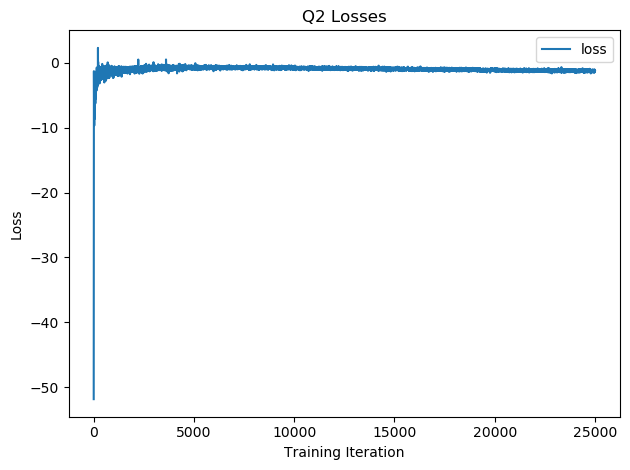

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


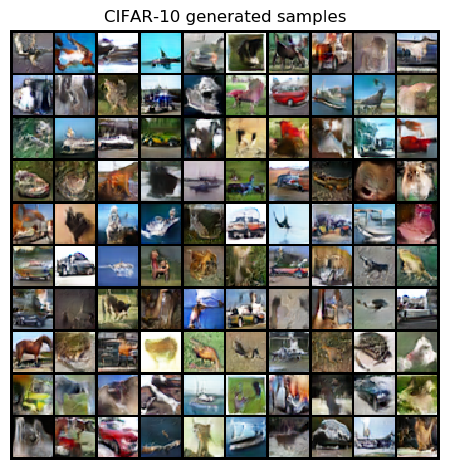

In [16]:
q2_save_results(q2)

# Question 3 : Quantization with GANS [40pt]
In this question, you'll train a variants of the VQGAN model to learn a mapping between image and a discrete codebook. We will do this on the CIFAR10 dataset.

## Part a: Vanilla VQGAN [25]
[VQGAN](https://github.com/CompVis/taming-transformers) extends the ideas from VQVAE by adding an additional GAN loss. Review HW 2 for more details on VQVAE, and may use your code from HW 2 (or HW2 solutions) to help with this question. Conceptually, the training procedure is the same as VQVAE, but with the addition of a discriminator network and its training.

Following the original VQGAN paper, we will use a patch-based discriminator. Split the image into 8x8 patches, which will be then fed into the discriminator. For the discrimiator you can use an architecture similar to the one used in the previous questions.
```
def Discriminator(*, n_filters=128):
    split to 8x8 patches
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.ReLU()
    global sum pooling
    nn.Linear(128, 1)
```

**Loss function**
We will use the loss function of

$L = L_{VQ} + 0.1 L_{GAN} + 0.5 L_{perceptual} + L_2$

Where $L_{VQ}$ is the VQ objective, $L_{GAN}$ is the GAN loss, $L_{perceptual}$ is the perceptual loss. 

For pytorch users, we provide the LPIPS loss from the original taming transformers paper ([found here](https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/lpips.py)). An example of using the LPIPS loss is found below. If you are using a different framework, feel free to use any off the shelf code, just make sure to cite where you take it from.

Instead of using the adaptive weight on the GAN loss, we will use a fixed weight of 0.1.
* train for at least 15 epochs
* use a codebook size of 1024
* use Adam with betas=(0.5, 0.9) and 0 weight decay for both optimizers
* use the non-saturating formulation of the GAN objective.

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.

In [17]:
# example usage of the LPIPS loss
from deepul.hw3_utils.lpips import LPIPS
loss = LPIPS()
x = torch.zeros(4, 3, 32, 32)
print(loss(x, x).mean())

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
tensor(0.)


In [3]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

device = "cuda"

import os
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple
import requests
from tqdm.notebook import tqdm


URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
import torch
import torch.nn as nn
import torch.nn.functional as F


class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)

    def forward(self, x):
        return self.gn(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResBlock(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3), padding=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, stride=1, padding=padding)
        )
        # The shortcut path is simply an identity if in_dim == n_filters
        # Otherwise, adapt the dimensions via a 1x1 convolution
        self.shortcut = nn.Conv2d(in_dim, n_filters, kernel_size=(1, 1), stride=1, padding=0) if in_dim != n_filters else nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv_block(x)
        return x + shortcut


class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output

class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super(Upsample_Conv2d, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        return x

class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super(Downsample_Conv2d, self).__init__()
        self.space_to_depth = SpaceToDepth(block_size=2)
        self.conv = nn.Conv2d(in_dim * 4, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.space_to_depth(x)
        x = self.conv(x)
        return x

class ResNetBlockUp(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        )
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        return self.block(x) + self.shortcut(x)

class ResNetBlockDown(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3), padding=1):
        super().__init__()
        # Main path: includes ReLU, downsample then convolutions without batch norm
        self.main_path = nn.Sequential(
            nn.ReLU(),
            Downsample_Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, stride=1, padding=padding)
        )
        # Shortcut path: downsample followed by a convolution, matching the main path's output dimensions
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), stride=1, padding=0)

    def forward(self, x):
        main_path = self.main_path(x)
        shortcut = self.shortcut(x)
        # Adding the main path and the shortcut together
        return main_path + shortcut

class ResBlock(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3), padding=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, stride=1, padding=padding)
        )
        # The shortcut path is simply an identity if in_dim == n_filters
        # Otherwise, adapt the dimensions via a 1x1 convolution
        self.shortcut = nn.Conv2d(in_dim, n_filters, kernel_size=(1, 1), stride=1, padding=0) if in_dim != n_filters else nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv_block(x)
        return x + shortcut


class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        # Assuming input image size is compatible with splitting into 8x8 patches directly or through an initial conv layer
        self.initial_layer = nn.Sequential(
            nn.Conv2d(3, n_filters, kernel_size=8, stride=8, padding=0),  # Example of converting to 8x8 patches if needed
            nn.ReLU()
        )
        self.res_block_down1 = ResNetBlockDown(3, n_filters)
        self.res_block_down2 = ResNetBlockDown(n_filters, n_filters)
        self.res_block1 = ResBlock(n_filters, n_filters)
        self.res_block2 = ResBlock(n_filters, n_filters)
        self.relu = nn.ReLU()
        self.global_pooling = nn.AdaptiveAvgPool2d((1, 1))  # Changed to adaptive avg pooling for simplicity; replace with sum pooling if necessary
        self.fc = nn.Linear(n_filters, 1)
        
    def forward(self, x):
        # x = self.initial_layer(x)  # Uncomment if your input needs to be directly converted to 8x8 patches
        x = self.res_block_down1(x)
        x = self.res_block_down2(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.relu(x)
        x = self.global_pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        channels = [128, 128, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 32
        layers = [nn.Conv2d(args.image_channels, channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], args.latent_dim, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        channels = [512, 256, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 8

        in_channels = channels[0]
        layers = [nn.Conv2d(args.latent_dim, in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, args.image_channels, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class Codebook(nn.Module):
    def __init__(self, args):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = args.num_codebook_vectors
        self.latent_dim = args.latent_dim
        self.beta = args.beta

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.latent_dim)

        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, min_encoding_indices, loss

class ResidualBlocks(nn.Module):
    def __init__(self, kernel_num):
        super().__init__()
        self.kernel_num = kernel_num
        self.net = nn.Sequential(
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
            nn.Conv2d(kernel_num, kernel_num, 3, 1, 1),
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
            nn.Conv2d(kernel_num, kernel_num, 3, 1, 1))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        x = x.to(self.device)
        return self.net(x) + x


class VQVAE(nn.Module):
    def __init__(self, latents_dim, latents_num):
        super().__init__()
        self.latents_dim = latents_dim
        self.latents_num = latents_num
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = nn.Sequential(nn.Conv2d(3, latents_dim, 4, 2, 1),
                                     nn.BatchNorm2d(latents_dim),
                                     nn.ReLU(),
                                     nn.Conv2d(latents_dim, latents_dim, 4, 2, 1),
                                     ResidualBlocks(latents_dim),
                                     ResidualBlocks(latents_dim)
                                     )
        self.decoder = nn.Sequential(ResidualBlocks(latents_dim),
                                     ResidualBlocks(latents_dim),
                                     nn.BatchNorm2d(latents_dim),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(latents_dim, latents_dim, 4, 2, 1),
                                     nn.BatchNorm2d(latents_dim),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(latents_dim, 3, 4, 2, 1))
        code_book = 2 * (torch.rand(size=(latents_num, latents_dim), requires_grad=True) - 0.5) / latents_num
        self.register_parameter("code_book", nn.Parameter(code_book, requires_grad=True))

    def forward(self, x):
        x = x.to(self.device)
        batch_size = x.shape[0]
        ze = self.encoder(x)
        ze_repeated = ze.unsqueeze(-1).repeat(1, 1, 1, 1, self.latents_num).permute(0, 2, 3, 4, 1)
        code_book_repeated = self.code_book.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch_size, 8, 8, 1, 1)
        distance = torch.sum((ze_repeated - code_book_repeated) ** 2, dim=-1)
        q_index = torch.argmin(distance, dim=-1)
        zq_with_grad = self.code_book[q_index].permute(0, 3, 1, 2)
        zq = ze + (zq_with_grad - ze).detach()
        outs = self.decoder(zq)
        recon_loss = (x - outs) ** 2
        vq_loss = (ze.detach() - zq_with_grad) ** 2
        commit_loss = (ze - zq_with_grad.detach()) ** 2
        return torch.mean(recon_loss), torch.mean(vq_loss), torch.mean(commit_loss), q_index.long(), outs

    def loss(self, x):
        losses = self(x)
        return torch.mean(losses[0] + losses[1] + losses[2])

    def sample(self, zq_index):
        zq = self.code_book[zq_index.long()]
        with torch.no_grad():
            return self.decoder(zq)

    def sample_pairs(self, x):
        x = torch.from_numpy(x).to(self.device)
        with torch.no_grad():
            results = self(x)
            reconstructed_images = results[-1]
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i].float(), reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().numpy()
    
from torchvision import utils as vutils
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(real_samples.device)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1) 
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class TrainVQGAN:
    def __init__(self, args):
        latents_dim = 256
        latents_num = 1024
        self.vqgan = VQVAE(latents_dim, latents_num).to(device)
        self.discriminator = Discriminator().to(device=args.device)
        self.perceptual_loss = LPIPS().eval().to(device=args.device)
        self.opt_vq, self.opt_disc = self.configure_optimizers(args)
        self.args = args


    def configure_optimizers(self, args):
        lr = args.learning_rate
        opt_vq = torch.optim.Adam(self.vqgan.parameters(),
            lr=lr, eps=1e-08, betas=(args.beta1, args.beta2)
        )
        opt_disc = torch.optim.Adam(self.discriminator.parameters(),
                                    lr=lr, eps=1e-08, betas=(args.beta1, args.beta2))

        return opt_vq, opt_disc


    def train(self, tran_tensor, val_tensor):
        train_dataset = DataLoader(tran_tensor, batch_size=self.args.batch_size, shuffle=True)
        val_dataset = DataLoader(val_tensor, batch_size=32, shuffle=True)
        steps_per_epoch = len(train_dataset)

        d_losses = []
        perceptual_losses = [] 
        l2_losses = []
        val_l2_losses = []
        
        for epoch in range(self.args.epochs):
            data_iter = iter(train_dataset)  
    
            with tqdm(enumerate(train_dataset), total=len(train_dataset), desc=f"Epoch {epoch+1}/{self.args.epochs}") as progress_bar:
                for i, imgs in progress_bar:
                    imgs = imgs.to(device=self.args.device)

                    self.opt_disc.zero_grad()
        
                    recon_loss, q_loss, commit_loss, _, decoded_images = self.vqgan(imgs)
        
                    disc_real = self.discriminator(imgs)
                    disc_fake = self.discriminator(decoded_images.detach())
                    d_loss_real = -torch.mean(disc_real)
                    d_loss_fake = torch.mean(disc_fake)
                    
                    gp = compute_gradient_penalty(self.discriminator, imgs, decoded_images.detach())
                    lambda_gp = 10
                    d_loss = d_loss_real + d_loss_fake + lambda_gp * gp

                    self.opt_disc.zero_grad()
                    d_loss.backward()
                    self.opt_disc.step()
                    d_losses.append(d_loss.item())
                    
                    
                    self.opt_vq.zero_grad()

                    disc_fake_for_gen = self.discriminator(decoded_images)
                    gan_loss = -torch.mean(disc_fake_for_gen)  
                    
                    perceptual_loss = self.perceptual_loss(imgs, decoded_images).mean()
                    
                    total_loss = q_loss + commit_loss + 0.1 * gan_loss + 0.5 * perceptual_loss + recon_loss
                    
                    self.opt_vq.zero_grad()
                    total_loss.backward()
                    self.opt_vq.step()

                    perceptual_losses.append(perceptual_loss.item())
                    l2_losses.append(recon_loss.item())

            
                    progress_bar.set_postfix(VQ_Loss=np.round(q_loss.item()+recon_loss.item(), 5),
                                     GAN_Loss=np.round(gan_loss.item(), 3),
                                     Perceptual_Loss=np.round(perceptual_loss.item(), 3),
                                     L2_Loss=np.round(recon_loss.item(), 3))

            if val_tensor is not None:
                val_l2_losses.append(self.validate(val_dataset))
            torch.save(self.vqgan.state_dict(), os.path.join("checkpoints", f"vqgan_epoch_{epoch}.pt"))
        return d_losses, perceptual_losses, l2_losses, val_l2_losses

    def validate(self, val_dataset):
        self.vqgan.eval() 
        total_l2_loss = 0.0
        total_samples = 0 
    
        with torch.no_grad():  
            for imgs in val_dataset:
                imgs = imgs.to(device=self.args.device)
                _,_,_,_,decoded_images = self.vqgan(imgs)
               
                l2_loss = (imgs - decoded_images).pow(2).mean()
                total_l2_loss += l2_loss.item() * imgs.size(0)  
                total_samples += imgs.size(0)  
    
        avg_l2_loss = total_l2_loss / total_samples  
        self.vqgan.train()  
        return avg_l2_loss
import argparse

def q3a(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.  
    """

    """ YOUR CODE HERE """
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    
    args = argparse.Namespace(
        image_size=32,
        beta=0.25,
        image_channels=3,
        dataset_path='/data',
        checkpoint_path='./checkpoints/last_ckpt.pt',
        device="cuda",
        batch_size=4,
        epochs=1,
        learning_rate=2.25e-05,
        beta1=0.5,
        beta2=0.9,
        disc_start=1000,
        disc_factor=1.,
        rec_loss_factor=1.,
        perceptual_loss_factor=1.
    )
    VQGAN = TrainVQGAN(args)
    d_losses, perceptual_losses, l2_losses, val_l2_losses = VQGAN.train(train_tensor, val_tensor)


    reconstruct_tensor = torch.tensor(reconstruct_data, dtype=torch.float32).to(device="cuda")
    batch_size = 4  
    
    total_batches = len(reconstruct_tensor) // batch_size + (0 if len(reconstruct_tensor) % batch_size == 0 else 1)
    
    all_reconstructions = []
    
    for i in range(total_batches):
        batch_tensor = reconstruct_tensor[i*batch_size:(i+1)*batch_size]
    
        print(f"Batch {i+1}/{total_batches}, reconstruct_tensor {batch_tensor.shape}")
        
        _, q_loss, _, _, decoded_images = VQGAN.vqgan(batch_tensor)
        print(f"{decoded_images.shape}")
    
        reconstructions_np = decoded_images.detach().cpu().numpy().transpose(0, 2, 3, 1)  
        all_reconstructions.append(reconstructions_np)
    
    all_reconstructions_np = np.concatenate(all_reconstructions, axis=0)
    

    return d_losses, perceptual_losses, l2_losses, val_l2_losses, all_reconstructions_np

In [4]:
q3_save_results(q3a, "a") # with pips

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/1: 100%|██████████| 12500/12500 [09:12<00:00, 22.62it/s, GAN_Loss=-6.62, L2_Loss=0.051, Perceptual_Loss=-0.01, VQ_Loss=0.156]  


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 7.57 GiB of which 1.72 GiB is free. Including non-PyTorch memory, this process has 5.12 GiB memory in use. Of the allocated memory 4.39 GiB is allocated by PyTorch, and 524.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

## Part b: VIT-VQGAN [15]
In this part, you will replace the encoder and decoder in the VQGAN with a Vision Transformer (ViT) following the [Improved VQGAN paper](https://arxiv.org/abs/2110.04627). You may use pre-built ViT modules and/or transformers libraries for the purposes of this exercise. Split images into 4x4 patches which should give you 8x8 patches for each image.

**Discriminator**
In ViT-VQGAN, the patch-based discriminator is replaced with a full StyleGAN discriminator. For the purposes of this exercise, you should use the same discrimiator as described in part a but without splitting into patches. In addition add [spectral normalization](https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html#torch-nn-utils-spectral-norm) to all the conv and linear layers and use LeakyReLU instead of ReLU, following [SN-GANs](https://arxiv.org/abs/1802.05957). This is to help with training stability.
```
def Discriminator(*, n_filters=128):
    # all conv layers in the ResBlocks should have spectral normalization
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.LeakyReLU()
    global sum pooling
    nn.Linear(128, 1)
```
* in addition add 

**Loss function**
$L = L_{VQ} + 0.1 L_{GAN} + \alpha L_{perceptual} + L_2 + 0.1 L_1$

The ViT-VQGAN paper introduces a new loss term $L_{Logit\_laplace}$ which is a logit laplace loss. For simplicity, we will use an L1 loss instead.

If you implemented the perceptual loss in the previous part, you can use the same perceptual loss here, otherwise you may keep $\alpha = 0$.


You should be able to largely be able to reuse your implementations in the previous part for this problem
The only 3 updates you need are:
* use ViT for encoder and decoder of VQVAE, use 4 layers, 8 heads, and 256 for the embedding size 
* add L1 loss
* change the discrimiator to look at the full image

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.


In [ ]:
import math
import numpy as np
from typing import Union, Tuple, List
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    """
    grid_size: int or (int, int) of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_size = (grid_size, grid_size) if type(grid_size) != tuple else grid_size
    grid_h = np.arange(grid_size[0], dtype=np.float32)
    grid_w = np.arange(grid_size[1], dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size[0], grid_size[1]])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)

    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def init_weights(m):
    if isinstance(m, nn.Linear):
        # we use xavier_uniform following official JAX ViT:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        w = m.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))


class PreNorm(nn.Module):
    def __init__(self, dim: int, fn: nn.Module) -> None:
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x: torch.FloatTensor, **kwargs) -> torch.FloatTensor:
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim: int, heads: int = 8, dim_head: int = 64) -> None:
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Linear(inner_dim, dim) if project_out else nn.Identity()

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        attn = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim: int, depth: int, heads: int, dim_head: int, mlp_dim: int) -> None:
        super().__init__()
        self.layers = nn.ModuleList([])
        for idx in range(depth):
            layer = nn.ModuleList([PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head)),
                                   PreNorm(dim, FeedForward(dim, mlp_dim))])
            self.layers.append(layer)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)


class Encoder(nn.Module):
    def __init__(self, image_size: Union[Tuple[int, int], int], patch_size: Union[Tuple[int, int], int],
                 dim: int, depth: int, heads: int, mlp_dim: int, channels: int = 3, dim_head: int = 64) -> None:
        super().__init__()
        image_height, image_width = image_size if isinstance(image_size, tuple) \
                                    else (image_size, image_size)
        patch_height, patch_width = patch_size if isinstance(patch_size, tuple) \
                                    else (patch_size, patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        en_pos_embedding = get_2d_sincos_pos_embed(dim, (image_height // patch_height, image_width // patch_width))

        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        self.patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size),
            Rearrange('b c h w -> b (h w) c'),
        )
        self.en_pos_embedding = nn.Parameter(torch.from_numpy(en_pos_embedding).float().unsqueeze(0), requires_grad=False)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.apply(init_weights)

    def forward(self, img: torch.FloatTensor) -> torch.FloatTensor:
        x = self.to_patch_embedding(img)
        x = x + self.en_pos_embedding
        x = self.transformer(x)

        return x


class Decoder(nn.Module):
    def __init__(self, image_size: Union[Tuple[int, int], int], patch_size: Union[Tuple[int, int], int],
                 dim: int, depth: int, heads: int, mlp_dim: int, channels: int = 3, dim_head: int = 64) -> None:
        super().__init__()
        image_height, image_width = image_size if isinstance(image_size, tuple) \
                                    else (image_size, image_size)
        patch_height, patch_width = patch_size if isinstance(patch_size, tuple) \
                                    else (patch_size, patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        de_pos_embedding = get_2d_sincos_pos_embed(dim, (image_height // patch_height, image_width // patch_width))

        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        self.patch_dim = channels * patch_height * patch_width

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)
        self.de_pos_embedding = nn.Parameter(torch.from_numpy(de_pos_embedding).float().unsqueeze(0), requires_grad=False)
        self.to_pixel = nn.Sequential(
            Rearrange('b (h w) c -> b c h w', h=image_height // patch_height),
            nn.ConvTranspose2d(dim, channels, kernel_size=patch_size, stride=patch_size)
        )

        self.apply(init_weights)

    def forward(self, token: torch.FloatTensor) -> torch.FloatTensor:
        x = token + self.de_pos_embedding
        x = self.transformer(x)
        x = self.to_pixel(x)

        return x

    def get_last_layer(self) -> nn.Parameter:
        return self.to_pixel[-1].weight
    
import PIL
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import transforms as T
import pytorch_lightning as pl
import importlib

import math
from functools import partial
from typing import Tuple, Optional
from omegaconf import OmegaConf
from typing import Tuple, List, Dict, ClassVar

import torch
import torch.nn as nn
import torch.nn.functional as F
def get_obj_from_str(name: str, reload: bool = False) -> ClassVar:
    module, cls = name.rsplit(".", 1)

    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
        
    return getattr(importlib.import_module(module, package=None), cls)

def initialize_from_config(config: OmegaConf) -> object:
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

class BaseQuantizer(nn.Module):
    def __init__(self, embed_dim: int, n_embed: int, straight_through: bool = True, use_norm: bool = True,
                 use_residual: bool = False, num_quantizers: Optional[int] = None) -> None:
        super().__init__()
        self.straight_through = straight_through
        self.norm = lambda x: F.normalize(x, dim=-1) if use_norm else x

        self.use_residual = use_residual
        self.num_quantizers = num_quantizers

        self.embed_dim = embed_dim
        self.n_embed = n_embed

        self.embedding = nn.Embedding(self.n_embed, self.embed_dim)
        self.embedding.weight.data.normal_()
        
    def quantize(self, z: torch.FloatTensor) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.LongTensor]:
        pass
    
    def forward(self, z: torch.FloatTensor) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.LongTensor]:
        if not self.use_residual:
            z_q, loss, encoding_indices = self.quantize(z)
        else:
            z_q = torch.zeros_like(z)
            residual = z.detach().clone()

            losses = []
            encoding_indices = []

            for _ in range(self.num_quantizers):
                z_qi, loss, indices = self.quantize(residual.clone())
                residual.sub_(z_qi)
                z_q.add_(z_qi)

                encoding_indices.append(indices)
                losses.append(loss)

            losses, encoding_indices = map(partial(torch.stack, dim = -1), (losses, encoding_indices))
            loss = losses.mean()

        # preserve gradients with straight-through estimator
        if self.straight_through:
            z_q = z + (z_q - z).detach()

        return z_q, loss, encoding_indices


class VectorQuantizer(BaseQuantizer):
    def __init__(self, embed_dim: int, n_embed: int, beta: float = 0.25, use_norm: bool = True,
                 use_residual: bool = False, num_quantizers: Optional[int] = None, **kwargs) -> None:
        super().__init__(embed_dim, n_embed, True,
                         use_norm, use_residual, num_quantizers)
        
        self.beta = beta

    def quantize(self, z: torch.FloatTensor) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.LongTensor]:
        z_reshaped_norm = self.norm(z.view(-1, self.embed_dim))
        embedding_norm = self.norm(self.embedding.weight)
        
        d = torch.sum(z_reshaped_norm ** 2, dim=1, keepdim=True) + \
            torch.sum(embedding_norm ** 2, dim=1) - 2 * \
            torch.einsum('b d, n d -> b n', z_reshaped_norm, embedding_norm)

        encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        encoding_indices = encoding_indices.view(*z.shape[:-1])
        
        z_q = self.embedding(encoding_indices).view(z.shape)
        z_qnorm, z_norm = self.norm(z_q), self.norm(z)
        
        # compute loss for embedding
        loss = self.beta * torch.mean((z_qnorm.detach() - z_norm)**2) +  \
               torch.mean((z_qnorm - z_norm.detach())**2)

        return z_qnorm, loss, encoding_indices


class ViTVQ(pl.LightningModule):
    def __init__(self, image_key: str, image_size: int, patch_size: int, encoder: OmegaConf, decoder: OmegaConf, quantizer: OmegaConf,
                 loss: OmegaConf, path: Optional[str] = None, ignore_keys: List[str] = list(), scheduler: Optional[OmegaConf] = None) -> None:
        super().__init__()
        self.path = path
        self.ignore_keys = ignore_keys 
        self.image_key = image_key
        self.scheduler = scheduler 
        
        self.loss = initialize_from_config(loss)
        self.encoder = Encoder(image_size=image_size, patch_size=patch_size, **encoder)
        self.decoder = Decoder(image_size=image_size, patch_size=patch_size, **decoder)
        self.quantizer = VectorQuantizer(**quantizer)
        self.pre_quant = nn.Linear(encoder.dim, quantizer.embed_dim)
        self.post_quant = nn.Linear(quantizer.embed_dim, decoder.dim)

        if path is not None:
            self.init_from_ckpt(path, ignore_keys)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:    
        quant, diff = self.encode(x)
        dec = self.decode(quant)
        
        return dec, diff

    def init_from_ckpt(self, path: str, ignore_keys: List[str] = list()):
        sd = torch.load(path, map_location="cpu")["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        self.load_state_dict(sd, strict=False)
        print(f"Restored from {path}")
        
    def encode(self, x: torch.FloatTensor) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        h = self.encoder(x)
        h = self.pre_quant(h)
        quant, emb_loss, _ = self.quantizer(h)
        
        return quant, emb_loss

    def decode(self, quant: torch.FloatTensor) -> torch.FloatTensor:
        quant = self.post_quant(quant)
        dec = self.decoder(quant)
        
        return dec

    def encode_codes(self, x: torch.FloatTensor) -> torch.LongTensor:
        h = self.encoder(x)
        h = self.pre_quant(h)
        _, _, codes = self.quantizer(h)
        
        return codes

    def decode_codes(self, code: torch.LongTensor) -> torch.FloatTensor:
        quant = self.quantizer.embedding(code)
        quant = self.quantizer.norm(quant)
        
        if self.quantizer.use_residual:
            quant = quant.sum(-2)  
            
        dec = self.decode(quant)
        
        return dec

    def get_input(self, batch: Tuple[Any, Any], key: str = 'image') -> Any:
        x = batch[key]
        if len(x.shape) == 3:
            x = x[..., None]
        if x.dtype == torch.double:
            x = x.float()

        return x.contiguous()

    def training_step(self, batch: Tuple[Any, Any], batch_idx: int, optimizer_idx: int = 0) -> torch.FloatTensor:
        x = self.get_input(batch, self.image_key)
        xrec, qloss = self(x)

        if optimizer_idx == 0:
            # autoencoder
            aeloss, log_dict_ae = self.loss(qloss, x, xrec, optimizer_idx, self.global_step, batch_idx,
                                            last_layer=self.decoder.get_last_layer(), split="train")

            self.log("train/total_loss", aeloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            del log_dict_ae["train/total_loss"]
            
            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=True)

            return aeloss

        if optimizer_idx == 1:
            # discriminator
            discloss, log_dict_disc = self.loss(qloss, x, xrec, optimizer_idx, self.global_step, batch_idx,
                                                last_layer=self.decoder.get_last_layer(), split="train")
            
            self.log("train/disc_loss", discloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            del log_dict_disc["train/disc_loss"]
            
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=True)
            
            return discloss

    def validation_step(self, batch: Tuple[Any, Any], batch_idx: int) -> Dict:
        x = self.get_input(batch, self.image_key)
        xrec, qloss = self(x)
        aeloss, log_dict_ae = self.loss(qloss, x, xrec, 0, self.global_step, batch_idx,
                                        last_layer=self.decoder.get_last_layer(), split="val")

        rec_loss = log_dict_ae["val/rec_loss"]

        self.log("val/rec_loss", rec_loss, prog_bar=True, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        self.log("val/total_loss", aeloss, prog_bar=True, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        del log_dict_ae["val/rec_loss"]
        del log_dict_ae["val/total_loss"]

        self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=True)

        if hasattr(self.loss, 'discriminator'):
            discloss, log_dict_disc = self.loss(qloss, x, xrec, 1, self.global_step, batch_idx,
                                                last_layer=self.decoder.get_last_layer(), split="val")
            
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=True)
        
        return self.log_dict

    def configure_optimizers(self) -> Tuple[List, List]:
        lr = self.learning_rate
        optim_groups = list(self.encoder.parameters()) + \
                       list(self.decoder.parameters()) + \
                       list(self.pre_quant.parameters()) + \
                       list(self.post_quant.parameters()) + \
                       list(self.quantizer.parameters())
        
        optimizers = [torch.optim.AdamW(optim_groups, lr=lr, betas=(0.9, 0.99), weight_decay=1e-4)]
        schedulers = []
        
        if hasattr(self.loss, 'discriminator'):
            optimizers.append(torch.optim.AdamW(self.loss.discriminator.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=1e-4))

        if self.scheduler is not None:
            self.scheduler.params.start = lr
            scheduler = initialize_from_config(self.scheduler)
            
            schedulers = [
                {
                    'scheduler': lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                } for optimizer in optimizers
            ]
   
        return optimizers, schedulers
        
    def log_images(self, batch: Tuple[Any, Any], *args, **kwargs) -> Dict:
        log = dict()
        x = self.get_input(batch, self.image_key).to(self.device)
        quant, _ = self.encode(x)
        
        log["originals"] = x
        log["reconstructions"] = self.decode(quant)
        
        return log



In [ ]:
def q3b(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.  
    """

    """ YOUR CODE HERE """

    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

In [ ]:
q3_save_results(q3b, "b")

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

In [ ]:
q4_save_results(q4)